### The goal here is predict the stock prices (trend) of google using Deep Learning

### We will attempt to do so via a Recurrent Neural Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [84]:
from google.colab import files
uploaded = files.upload()

Saving Stock_Price_Train.csv to Stock_Price_Train (1).csv


In [85]:
import io
train = pd.read_csv(io.BytesIO(uploaded['Stock_Price_Train.csv']))

In [86]:
train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [6]:
# Stock prices of all the financial days from 2012 to the end of 2016
train.shape

(1258, 6)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [8]:
train['Dates']= pd.to_datetime(train['Date']) 

Text(0.5, 1.0, 'Google Stock Price over 5 years - (1/3/2012 - 12/30/2016)')

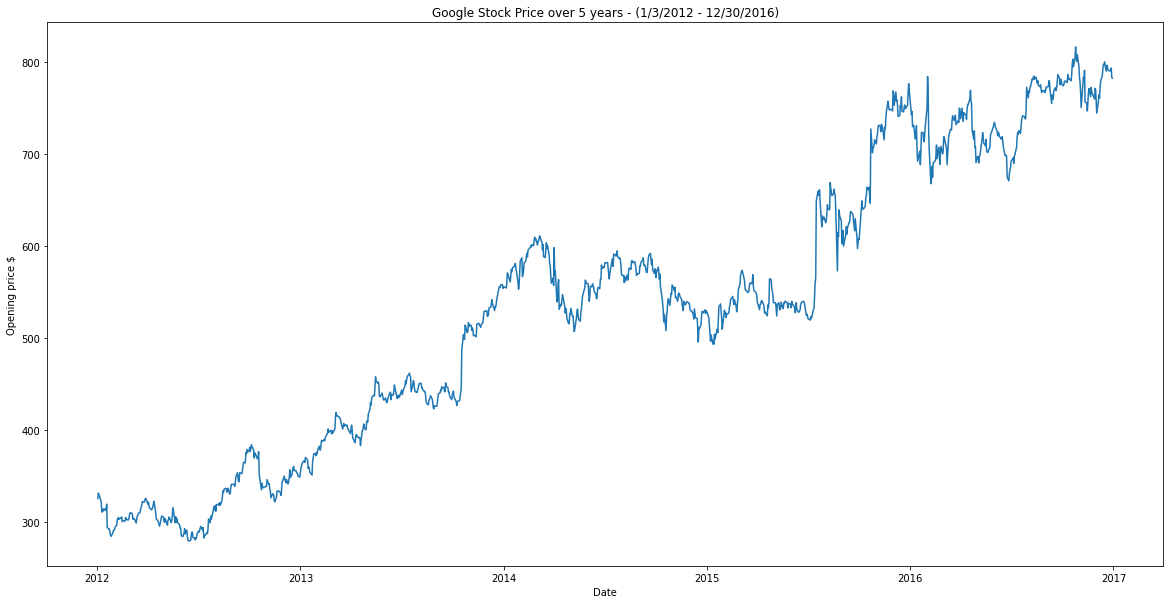

In [9]:
# Plotting the stock trend in our training data
plt.figure(figsize=(20,10))
plt.plot(train['Dates'], train['Open'])
plt.xlabel("Date")
plt.ylabel("Opening price $")
plt.title("Google Stock Price over 5 years - (1/3/2012 - 12/30/2016)")

In [10]:
# Selecting the required open cost price column into an nd array to train the RNN on 
training_set = train.iloc[:, 1:2].values
training_set

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

### Data Preprocessing

In [11]:
# Scaling the data 
# Using min max normalization for RNN with sigmoid activation function
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
mms_training_set = mms.fit_transform(training_set)

In [12]:
mms_training_set[0:10]

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       [0.09156187],
       [0.07984225],
       [0.0643277 ],
       [0.0585423 ],
       [0.06568569],
       [0.06109085],
       [0.06639259]])

In [63]:
# When dealing with RNNs we need to create a data structure of size n wherein
# at every point in time the RNN would look back to the last n values of the data structures values holding the stock prices to make the immediate next prediction based on their trend
# 60 arbitratily selected over multiple trial and error iterations
X_train = []
y_train = []
for i in range(60, 1258):
    X_train.append(mms_training_set[i-60:i, 0])
    y_train.append(mms_training_set[i, 0])
# Converting the generated lists into nd arrays
X_train, y_train = np.array(X_train), np.array(y_train)

In [50]:
X_train[0:1]

array([[0.08581368, 0.09701243, 0.09433366, 0.09156187, 0.07984225,
        0.0643277 , 0.0585423 , 0.06568569, 0.06109085, 0.06639259,
        0.0614257 , 0.07474514, 0.02797827, 0.02379269, 0.02409033,
        0.0159238 , 0.01078949, 0.00967334, 0.01642607, 0.02100231,
        0.02280676, 0.02273235, 0.02810849, 0.03212665, 0.0433812 ,
        0.04475779, 0.04790163, 0.0440695 , 0.04648783, 0.04745517,
        0.04873875, 0.03936305, 0.04137213, 0.04034898, 0.04784582,
        0.04325099, 0.04356723, 0.04286033, 0.04602277, 0.05398467,
        0.05738894, 0.05714711, 0.05569611, 0.04421832, 0.04514845,
        0.04605997, 0.04412531, 0.03675869, 0.04486941, 0.05065481,
        0.05214302, 0.05612397, 0.05818885, 0.06540665, 0.06882953,
        0.07243843, 0.07993526, 0.07846566, 0.08034452, 0.08497656]])

In [64]:
y_train[0:1]

array([0.08627874])

In [65]:
# Reshaping to appropriately fit the Keras RNN

In [81]:
X_train.shape

(1198, 60, 1)

In [20]:
# The input shape of an RNN in Keras is a 3D tensor with shape (batchsize, timesteps, input_dim)
# batchsize -  is the number of observations which is in our case 1188
# timesteps - the total nummber of timesteps defined - 70
# input_dim - is the dimension that can correspond to other indicators besides price that may add value to the prediction

In [67]:
# To add the third dimension to the nd array
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

### Building and Training the RNN

In [68]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [69]:
# Creatunga stacjed LSTM RNN
# Initialising the RNN
rnn_lstm = Sequential()
# Adding the first LSTM layer and some Dropout regularisation to avoid overfiting 
# units represent the number of LSTM cells we want to have
# return_sequences is true since we want to make a stacked LSTM
# 0.2 is about 20% of units will be dropped
rnn_lstm.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
rnn_lstm.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
rnn_lstm.add(LSTM(units = 60, return_sequences = True))
rnn_lstm.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
rnn_lstm.add(LSTM(units = 60, return_sequences = True))
rnn_lstm.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
rnn_lstm.add(LSTM(units = 60, return_sequences = True))
rnn_lstm.add(Dropout(0.2))
# Adding a fifth LSTM layer and some Dropout regularisation
# return_sequences is False by default
rnn_lstm.add(LSTM(units = 60))
rnn_lstm.add(Dropout(0.2))
# Adding the output layer
rnn_lstm.add(Dense(units = 1))

In [70]:
# Compiling the RNN
# adam optimizer is an implementation of stochastic gradient descent we could also try RMSprop
rnn_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [71]:
# Fitting the RNN to the Training set
# weight is updated based on batch size i.e. every 32 stock prices
import timeit
start_time = timeit.default_timer()
rnn_lstm.fit(X_train, y_train, epochs = 150, batch_size = 32)
elapsed = timeit.default_timer() - start_time

Epoch 1/150
38/38 [==============================] - 6s 147ms/step - loss: 0.0410
Epoch 2/150
38/38 [==============================] - 6s 150ms/step - loss: 0.0064
Epoch 3/150
38/38 [==============================] - 6s 152ms/step - loss: 0.0055
Epoch 4/150
38/38 [==============================] - 6s 153ms/step - loss: 0.0053
Epoch 5/150
38/38 [==============================] - 6s 158ms/step - loss: 0.0050
Epoch 6/150
38/38 [==============================] - 6s 156ms/step - loss: 0.0055
Epoch 7/150
38/38 [==============================] - 6s 154ms/step - loss: 0.0050
Epoch 8/150
38/38 [==============================] - 6s 152ms/step - loss: 0.0060
Epoch 9/150
38/38 [==============================] - 6s 151ms/step - loss: 0.0047
Epoch 10/150
38/38 [==============================] - 6s 155ms/step - loss: 0.0044
Epoch 11/150
38/38 [==============================] - 6s 157ms/step - loss: 0.0041
Epoch 12/150
38/38 [==============================] - 6s 157ms/step - loss: 0.0044
Epoch 13/150


In [72]:
print("\nThe model ran in "+ str(elapsed) +" seconds.")


The model ran in 953.536131884 seconds.


In [75]:
# We began with a loss value of 0.0401 and converged with a value of 0.0011 at the end of 150 epochs

### Making the prediction

In [88]:
from google.colab import files
uploaded = files.upload()

Saving Stock_Price_Test.csv to Stock_Price_Test (2).csv


In [89]:
test = pd.read_csv(io.BytesIO(uploaded['Stock_Price_Test.csv']))
real_stock_price = test.iloc[:, 1:2].values

In [78]:
test.shape

(20, 6)

In [90]:
test.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


##### Getting the predicted stock price


In [91]:
dataset_total = pd.concat((train['Open'], test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 60:].values

In [92]:
inputs

array([779.  , 779.66, 777.71, 786.66, 783.76, 781.22, 781.65, 779.8 ,
       787.85, 798.24, 803.3 , 795.  , 804.9 , 816.68, 806.34, 801.  ,
       808.35, 795.47, 782.89, 778.2 , 767.25, 750.66, 774.5 , 783.4 ,
       779.94, 791.17, 756.54, 755.6 , 746.97, 755.2 , 766.92, 771.37,
       762.61, 772.63, 767.73, 764.26, 760.  , 771.53, 770.07, 757.44,
       744.59, 757.71, 764.73, 761.  , 772.48, 780.  , 785.04, 793.9 ,
       797.4 , 797.34, 800.4 , 790.22, 796.76, 795.84, 792.36, 790.9 ,
       790.68, 793.7 , 783.33, 782.75, 778.81, 788.36, 786.08, 795.26,
       806.4 , 807.86, 805.  , 807.14, 807.48, 807.08, 805.81, 805.12,
       806.91, 807.25, 822.3 , 829.62, 837.81, 834.71, 814.66, 796.86])

In [93]:
inputs = inputs.reshape(-1,1)

In [94]:
inputs[0:10]

array([[779.  ],
       [779.66],
       [777.71],
       [786.66],
       [783.76],
       [781.22],
       [781.65],
       [779.8 ],
       [787.85],
       [798.24]])

In [95]:
inputs = mms.transform(inputs)

In [96]:
# Creating the 3 dimensional input
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [97]:
predicted_stock_price = rnn_lstm.predict(X_test)

In [98]:
predicted_stock_price = mms.inverse_transform(predicted_stock_price)

### Visualising the results

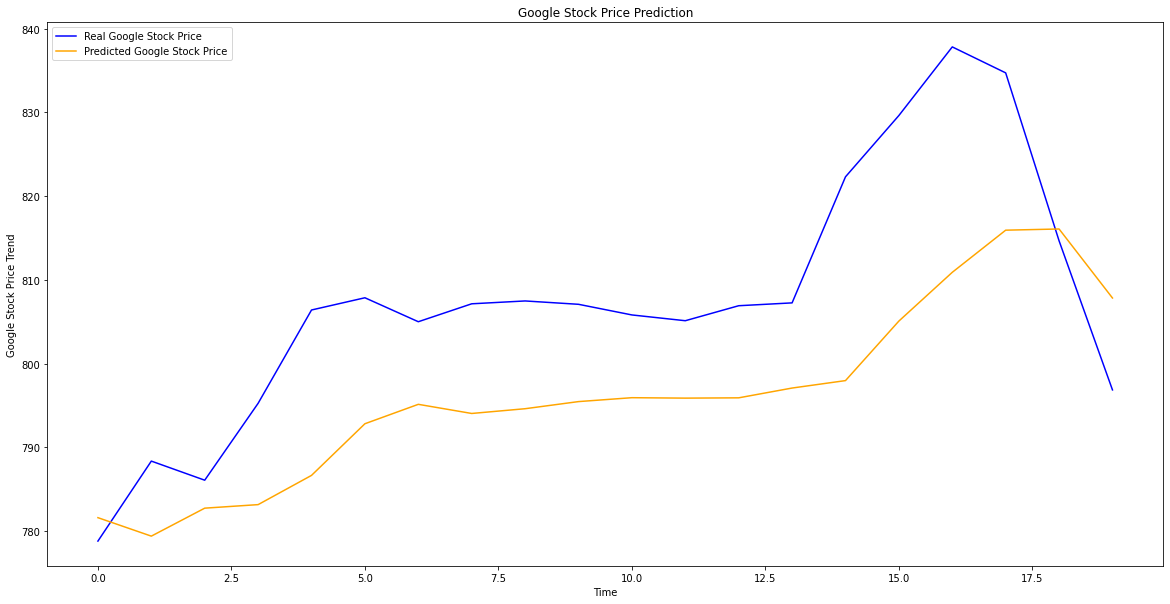

In [107]:
# Based on the Brownian Motion we know that it is impossible to predict the exact stock prices of any stock but here we can see that our LSTM has done a pretty good job at 
# predicting the upward/downward trend of the stock
plt.figure(figsize=(20,10))
plt.plot(real_stock_price, color = 'blue', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'orange', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price Trend')
plt.legend()
plt.show()